$x_{norm} = \frac{(x-x_{mean})}{x_{std}}$

$x_{denorm} = (x_{norm} \times x_{std}) + x_{mean}$


In [2]:
import numpy as np

x = np.array([1, 2, 3])
x_norm = (x - x.mean()) / x.std()

x_denorm = x_norm * x.std() + x.mean()

print(x_denorm)

[1. 2. 3.]


In [21]:
import numpy as np
import torch
import torchvision.transforms as transforms

In [22]:
from scipy.stats import wasserstein_distance

In [23]:
model_metadata = {

    "container_info": {
        "container_type": "apptainer", # Choose appropriate container type
        "container_version": "1.2", # Version of the container
        "container_author": "John Doe", # Author of the container. Likely, but not necessarily, the same as the author of the model.
        "container_date": "2023-04-01", # Date of the last containerization
        "notes": "..." # Include any additional information about the container
    },

    "model_info" : {

        "githhub_repo": "https://github.com/Jonh_D/RF_models.git", # Link to the github repo where the code to train/test the model is stored
        "model_name": "RFR_36_months_pgm_africa_middle_east_2023_04_01", #Unique name for the model. Preferably describtive including algorithm, the temp forecasting window, loa, and date of training.
        "model_description": "Random Forest Regressor trained for a 36 forecasting window using Stepshifter v.3.0 for pgm loa Africa and Middle East", # Description of the model
        "model_version": "1.0", # Version of the model
        "model_author": "John Doe", # Author of the model
        "model_date": "2023-04-01", # Date of the last model training, testing and evaluation before containerization.

        "regression_task": True,
        "regression_optimization_criteria": "squared_error", # Chioose appropriate regression criteria. Must relflect then name used in the documentation of the model.
        
        "classification_task": False,
        "classification_optimization_criteria": None, # Choose appropriate classification criteria

        "loa" : "pgm", #for instance "pgm" (prio grid month), "cm" (contry month), "am" (actor month), "pgy" (prio grid year), "cy" (country year), "ay" (actor year)

        "model_algorithm": "RandomForestRegressor",  # Choose appropriate ML algorithm
        "model_library": "sklearn",  # Choose appropriate ML library
        "model_dependencies": ["numpy 1.19.2", "pandas 1.1.3", "scikit-learn 0.23.2"],  # List of dependencies and their versions
        "notes": "..." # Include any additional information about the model
    },

    "hyperparameters": { # Include all hyperparameters used for the model training. Must be compatible with W&B config format. Exact hyperparameters included and naming convention will depend on the specific model.
        "criterion": "squared_error", # Choose appropriate criterion
        "n_estimators": 100,
        "max_depth": 10,
        "learning_rate": 0.01,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "min_weight_fraction_leaf": 0.0,
        "max_features": "auto",
        "max_leaf_nodes": None,
        "min_impurity_decrease": 0.0,
        "min_impurity_split": None,
        "bootstrap": True,
        "oob_score": False,
        "n_jobs": -1,
        "random_state": 42,
        "verbose": 0,
        "warm_start": False,
        "ccp_alpha": 0.0,
        "max_samples": None,
        # ...
        "notes" : "..." #Include any additional information about the hyperparameters
    },

    "feature_info": {
        "feature_names": ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6", "feature_7", "feature_8" ],
        "optained_from": "VIEWERS API v.3.0",
        "optained_date": "2023-04-01",
        "notes" : "..." #Include any additional information about the features
        },

    "target_info": {
        "target_names": ["sb_best"], # List of target names. If a target is logged, normalized, or outerwise transformed, this should be reflected in the name. eg. "sb_best_ln"
        "optained_from": "VIEWERS API v.3.0",
        "optained_date": "2023-04-01",
        "notes" : "..." #Include any additional information about the target
        },

    "temporal_forecasting_window": { # realtive to end of history.
        "temporal_granularity": "month", # Choose appropriate temporal granularity. Must be consistent with loa.
        "first_step": 0,
        "last_step": 35,
        "notes": "..."
    },

    "geographical_forecasting_window": {
        "geographical_granularity": "prio_grid_cell", # Choose appropriate geographical granularity. Must be consistent with loa.
        "Africa": True,
        "Middle East": True,
        "Asia": False,
        "Europe": False,
        "Americas": False,
        "Oceania": False,
        "custom": False, # If True, specify custom geographical forecasting window custom_window notes. 
        "custom_window" : [], # If custom = Flase, leave list empty. If custom = True, specify custom geographical forecasting window here. For instance "Ukrain", or a list of countries, a list of prio grid cells.
        "notes": "..."
    },

    "actor_forcasting_window": { # only for loa = "am" or "ay"
        "state_actors" : [None], # List of all state actors included in the forecasts. If None, no actors specific forcasts are included.
        "non_state_actors" : [None], # List of all non-state actors included in the forecasts. If None, no actors specific forcasts are included.

        "notes": "..."
    },

    "training_info": {
        "start_month_id": 0,
        "end_month_id": 399,
        "notes": "...", #Include special considerations or notes for the training set
    },

    "validation_info": {
        "start_month_id": 400,
        "end_month_id": 599,
        "notes": "...", #Provide any specific details or constraints for the validation set. Perticualrly whether or not it was validated across multiple temporal forecasting windows.
    },

    "testing_info": {
        "start_month_id": 600,
        "end_month_id": 636,
        "notes": "...", #Include information about the test set, such as any external factors affecting the data
    },

    "evaluation_metrics":{ 
        "step_wise": # Step is relative to end of history. Suggested step-specific enemble weights can be supplied by researcher.
        [
            {"step": 0, "MSE": 0.79493354, "MAE": 0.42519962, "MSLE": 0.12345678, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
            {"step": 1, "MSE": 0.68004244, "MAE": 0.34056406, "MSLE": 0.10353466, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
            #...
            {"step": 36, "MSE": 0.5064236, "MAE": 0.23054364, "MSLE": 0.08345464, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
        ],
        "mean" : {"MSE": 0.6538689, "MAE": 0.33056365, "MSLE": 0.10345545, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
        "std" : {"MSE": 0.0043682, "MAE": 0.00156365, "MSLE": 0.00345563, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
        "median" : {"MSE": 0.6538689, "MAE": 0.33056365, "MSLE": 0.10345545, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
    }
}

In [24]:
model_metadata = {

    "container_info": {
        "container_type": "apptainer", # Choose appropriate container type
        "container_version": "1.2", # Version of the container
        "container_author": "John Doe", # Author of the container. Likely, but not necessarily, the same as the author of the model.
        "container_date": "2023-04-01", # Date of the last containerization
        "notes": "..." # Include any additional information about the container
    },

    "model_info": {

        "githhub_repo": "https://github.com/Jonh_D/RF_models.git", # Link to the github repo where the code to train/test the model is stored
        "model_name": "RFR_36_months_pgm_africa_middle_east_2023_04_01", #Unique name for the model. Preferably describtive including algorithm, the temp forecasting window, loa, and date of training.
        "model_description": "Random Forest Regressor trained for a 36 forecasting window using Stepshifter v.3.0 for pgm loa Africa and Middle East", # Description of the model
        "model_version": "1.0", # Version of the model
        "model_author": "John Doe", # Author of the model
        "model_date": "2023-04-01", # Date of the last model training, testing, and evaluation before containerization.

        "regression_task": True, # note that some models may be solving both regression and classification tasks. In this case, both regression_task and classification_task should be set to True.
        "regression_optimization_criteria": "squared_error", # Chioose appropriate regression criteria. Must reflect the name used in the documentation of the model.
        
        "classification_task": False,# note that some models may be solving both regression and classification tasks. In this case, both regression_task and classification_task should be set to True.
        "classification_optimization_criteria": None, # Choose appropriate classification criteria. Must reflect the name used in the documentation of the model.

        "loa": "pgm", #for instance "pgm" (prio grid month), "cm" (country month), "am" (actor month), "pgy" (prio grid year), "cy" (country year), "ay" (actor year)

        "model_algorithm": "RandomForestRegressor",  # Choose appropriate ML algorithm
        "model_library": "sklearn",  # Choose appropriate ML library
        "model_dependencies": ["numpy 1.19.2", "pandas 1.1.3", "scikit-learn 0.23.2"],  # List of dependencies and their versions
        "notes": "..." # Include any additional information about the model
    },

    "hyperparameters": { # Include all hyperparameters used for the model training. Must be compatible with W&B config format. Exact hyperparameters included and naming convention will depend on the specific model.
        "criterion": "squared_error", # Choose appropriate criterion
        "n_estimators": 100,
        "max_depth": 10,
        "learning_rate": 0.01,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "min_weight_fraction_leaf": 0.0,
        "max_features": "auto",
        "max_leaf_nodes": None,
        "min_impurity_decrease": 0.0,
        "min_impurity_split": None,
        "bootstrap": True,
        "oob_score": False,
        "n_jobs": -1,
        "random_state": 42,
        "verbose": 0,
        "warm_start": False,
        "ccp_alpha": 0.0,
        "max_samples": None,
        # ...
        "notes" : "..." #Include any additional information about the hyperparameters
    },

    "uncertainty_info": {
        "uncertainty_quantification": False, # If True, the model provides a sample of predictions for each forecasted temporal unit. If False the model provides a point estimate for each forecasted temporal unit.
        "uncertainty_method": None, # Choose appropriate uncertainty type, for instance "ensemble", "dropout", "bayesian", "bootstrap", conformal prediction", etc. If uncertainty_estimate = False, this should be None.
        "uncertainty_samples": 1, # Number of samples drawn from the uncertainty distribution. If uncertainty_estimate = False, this should be 1.
        "notes": "..." # Include any additional information about the uncertainty
    },

    "feature_info": {
        "feature_names": ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6", "feature_7", "feature_8" ],
        "optained_from": ["VIEWERS API v.3.0"], # If features are from different sources please elabotare in notes
        "optained_date": "2023-04-01",
        "notes" : "..." #Include any additional information about the features
        },

    "target_info": {
        "target_names": ["sb_best"], # List of target name(s). If a target is logged, normalized, or otherwise transformed, this should be reflected in the name. eg. "sb_best_ln"
        "target_types": ["continuous"], # Choose appropriate target type. usually "continuous" or "binary". Noted that the order of this list must match the order of the target_names list.
        "optained_from": ["VIEWERS API v.3.0"], #If there are multiple target and they are from different sources please elaborate in notes
        "optained_date": "2023-04-01",
        "notes" : "..." #Include any additional information about the target
        },

    "temporal_forecasting_window": { # realtive to end of history.
        "temporal_granularity": "month", # Choose appropriate temporal granularity. Must be consistent with loa.
        "first_step": 0,
        "last_step": 35,
        "notes": "..."
    },

    "geographical_forecasting_window": {
        "geographical_granularity": "prio_grid_cell", # Choose appropriate geographical granularity. Must be consistent with LOA.
        "Africa": True,
        "Middle East": True,
        "Asia": False,
        "Europe": False,
        "Americas": False,
        "Oceania": False,
        "custom": False, # If True, specify custom geographical forecasting window custom_window notes. 
        "custom_window" : [], # If custom = Flase, leave the list empty. If custom = True, specify the custom geographical forecasting window here. For instance "Ukraine", or a list of countries, a list of prio grid cells.
        "notes": "..."
    },

    "actor_forcasting_window": { # only for loa = "am" or "ay"
        "state_actors" : [None], # List of all state actors included in the forecasts. If None, no actors-specific forecasts are included.
        "non_state_actors" : [None], # List of all non-state actors included in the forecasts. If None, no actors-specific forecasts are included.

        "notes": "..."
    },

    "training_info": {
        "start_month_id": 0,
        "end_month_id": 399,
        "notes": "...", #Include special considerations or notes for the training set
    },

    "validation_info": {
        "start_month_id": 400,
        "end_month_id": 599,
        "notes": "...", #Provide any specific details or constraints for the validation set. Particularly whether or not it was validated across multiple temporal forecasting windows.
    },

    "testing_info": {
        "start_month_id": 600,
        "end_month_id": 636,
        "notes": "...", #Include information about the test set, such as any external factors affecting the data
    },

		"evaluation_metrics":{ 
        "step_wise": # Step is relative to end of history. Suggested step-specific ensemble weights may be supplied by the researcher but these are not necessarily to ones used in a given ensemble down stream.
        [
            {"step": 0, "MSE": 0.79493354, "MAE": 0.42519962, "MSLE": 0.12345678, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
            {"step": 1, "MSE": 0.68004244, "MAE": 0.34056406, "MSLE": 0.10353466, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
            #...
            {"step": 36, "MSE": 0.5064236, "MAE": 0.23054364, "MSLE": 0.08345464, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
        ],
        "mean" : {"MSE": 0.6538689, "MAE": 0.33056365, "MSLE": 0.10345545, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
        "std" : {"MSE": 0.0043682, "MAE": 0.00156365, "MSLE": 0.00345563, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
        "median" : {"MSE": 0.6538689, "MAE": 0.33056365, "MSLE": 0.10345545, "KLD": None, "Jeffreys": None, "CRPS": None, "Brier": None, "AP": None, "AUC": None, "ensemble_weight_reg": None, "ensemble_weight_class": None},
    }
}

In [25]:
model_metadata["evaluation_metrics"]['step_wise'][-1]

{'step': 36,
 'MSE': 0.5064236,
 'MAE': 0.23054364,
 'MSLE': 0.08345464,
 'KLD': None,
 'Jeffreys': None,
 'CRPS': None,
 'Brier': None,
 'AP': None,
 'AUC': None,
 'ensemble_weight_reg': None,
 'ensemble_weight_class': None}

In [26]:
model_metadata['validation_info']

{'start_month_id': 400, 'end_month_id': 599, 'notes': '...'}

In [27]:
#CRPS


In [28]:
def tweedie_loss(p, q, pow=1.5, eps=np.exp(-100)):

    p = p + eps
    q = q + eps 

    loss = -p * np.power(q, 1 - pow) / (1 - pow) + np.power(q, 2 - pow) / (2 - pow)
    return np.mean(loss)

In [29]:
def robust_kl_divergence(p, q, eps=np.exp(-100)):

    p = p + eps
    q = q + eps

    return np.sum(p * np.log(p / q))

In [30]:
def jeffreys_divergence(p, q, eps=np.exp(-100)):

    p = p + eps
    q = q + eps

    return 0.5 * np.sum((p - q) * np.log(p / q))

In [31]:
def jenson_shannon_divergence(p, q, eps=np.exp(-100)):

    p = p + eps
    q = q + eps

    m = 0.5 * (p + q)

    return 0.5 * np.sum(p * np.log(p / m) + q * np.log(q / m))

In [32]:
def gini_coefficient_cdf(p, q, eps=np.exp(-100)):
    # Sort the values in ascending order
    sorted_values_p = np.sort(p + eps)
    sorted_values_q = np.sort(q + eps)
    
    # Calculate the cumulative distribution functions (CDFs)
    cdf_p = np.cumsum(sorted_values_p) / np.sum(sorted_values_p)
    cdf_q = np.cumsum(sorted_values_q) / np.sum(sorted_values_q)
    
    # Calculate the Gini coefficient based on CDFs
    gini_coefficient_p = 1 - 2 * np.sum(cdf_p) / len(cdf_p)
    gini_coefficient_q = 1 - 2 * np.sum(cdf_q) / len(cdf_q)
    
    # Calculate the absolute difference of Gini coefficients
    gini_difference = np.abs(gini_coefficient_p - gini_coefficient_q)
    
    return gini_difference

In [33]:
def jaccard_similarity(p, q, eps=np.exp(-100)):

    intersection_size = len(p.intersection(q))
    union_size = len(p.union(q))

    if union_size == 0:
        return 0.0  # Handle the case where both sets are empty

    jaccard_coefficient = intersection_size / union_size
    return jaccard_coefficient

In [34]:
def bhattacharyya_distance(p, q, eps=np.exp(-100)):

    p = p + eps
    q = q + eps

    # Ensure both distributions have the same length
    assert len(p) == len(q)
    # Calculate the Bhattacharyya coefficient
    bhattacharyya_coefficient = np.sum(np.sqrt(p * q))

    # Calculate the Bhattacharyya Distance
    bhattacharyya_dist = -np.log(bhattacharyya_coefficient)

    return bhattacharyya_dist

In [35]:
def hellinger_distance(p, q, eps=np.exp(-100)):

    p = p + eps
    q = q + eps

    # Ensure both distributions have the same length
    assert len(p) == len(q), "Input distributions must have the same length."

    # Calculate the Hellinger Distance
    hellinger_dist = np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

    return hellinger_dist

In [36]:
from scipy.optimize import linear_sum_assignment

def earth_movers_distance(p, q):
    """
    Compute Earth Mover's Distance between two probability distributions.

    Parameters:
    - p, q: 1D NumPy arrays representing probability distributions.

    Returns:
    - emd: Earth Mover's Distance between p and q.
    """
    # Ensure both distributions have the same length
    assert len(p) == len(q), "Input distributions must have the same length."

    # Calculate the cost matrix
    cost_matrix = np.abs(np.subtract.outer(p, q))

    # Solve the linear sum assignment problem (minimum cost bipartite matching)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    # Calculate the Earth Mover's Distance
    emd = cost_matrix[row_indices, col_indices].sum()

    return emd

In [37]:
def sinkhorn_distance(p, q, epsilon=1e-3, max_iters=100):
    """
    Compute Sinkhorn distance approximation between two probability distributions.

    Parameters:
    - p, q: 1D NumPy arrays representing probability distributions.
    - epsilon: Regularization parameter.
    - max_iters: Maximum number of iterations for Sinkhorn-Knopp algorithm.

    Returns:
    - sinkhorn_dist: Approximate Sinkhorn distance between p and q.
    """

    p = p + np.exp(-100)
    q = q + np.exp(-100)

    # Ensure both distributions have the same length
    assert len(p) == len(q), "Input distributions must have the same length."

    # Define the cost matrix
    cost_matrix = np.abs(np.subtract.outer(p, q))

    # Sinkhorn-Knopp algorithm
    K = np.exp(-cost_matrix / epsilon)
    a = np.ones_like(p)
    b = np.ones_like(q)

    for _ in range(max_iters):
        # Update dual variables
        u = a / K.sum(axis=1)
        v = b / (K.T).sum(axis=1)

        # Update primal variables
        K = np.exp(np.log(K) - epsilon * (u[:, None] + v[None, :]))

    # Calculate Sinkhorn distance
    sinkhorn_dist = np.sum(u[:, None] * K * v[None, :])

    return sinkhorn_dist

In [38]:
def cosine_similarity(vector1, vector2):
    """
    Calculate the cosine similarity between two vectors.

    Parameters:
    - vector1, vector2: 1D NumPy arrays representing vectors.

    Returns:
    - cosine_similarity: Cosine similarity between the two vectors.
    """
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)

    if norm_vector1 == 0 or norm_vector2 == 0:
        return 0.0  # Handle the case where one or both vectors are zero vectors

    cosine_similarity = dot_product / (norm_vector1 * norm_vector2)
    return cosine_similarity

In [39]:
def zero_inflated_distribution(num_data_points = 10000):

    data = np.zeros(num_data_points)

    # add non-zero data points
    num_non_zero = int(num_data_points * 0.5)
    non_zero_indices = np.random.choice(num_data_points, num_non_zero, replace=False)

    # add 0.1% +1000 values
    num_1000 = int(num_data_points * 0.001)
    indices_1000 = np.random.choice(num_data_points, num_1000, replace=False)

    # complie the data
    data[non_zero_indices] = np.random.randint(1, 100, num_non_zero)
    data[indices_1000]= np.random.randint(100, 10000, num_1000)

    return data
    

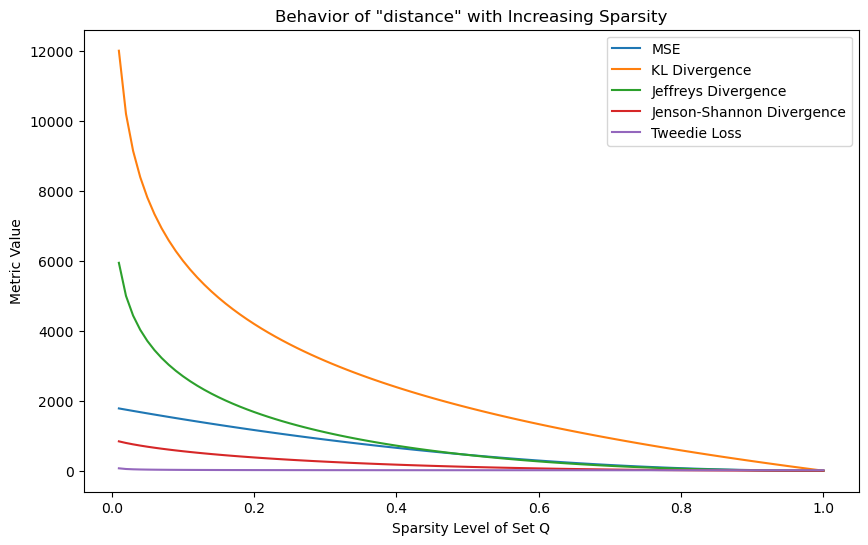

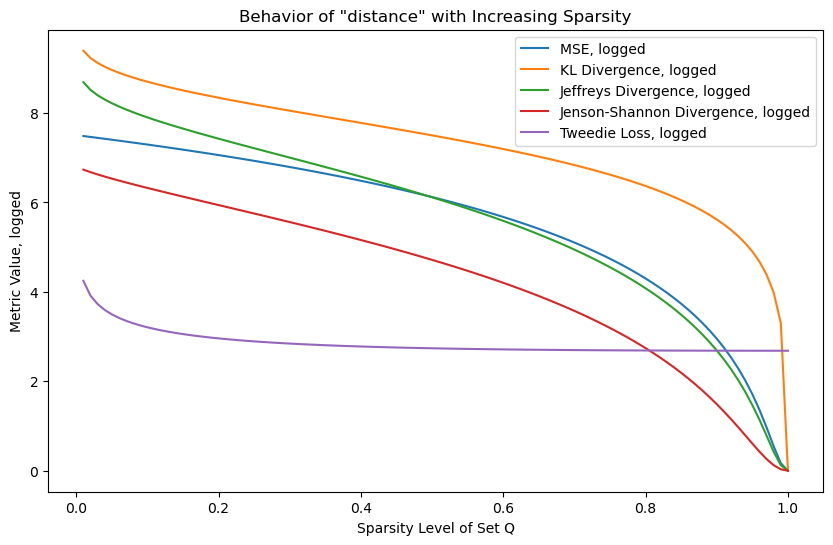

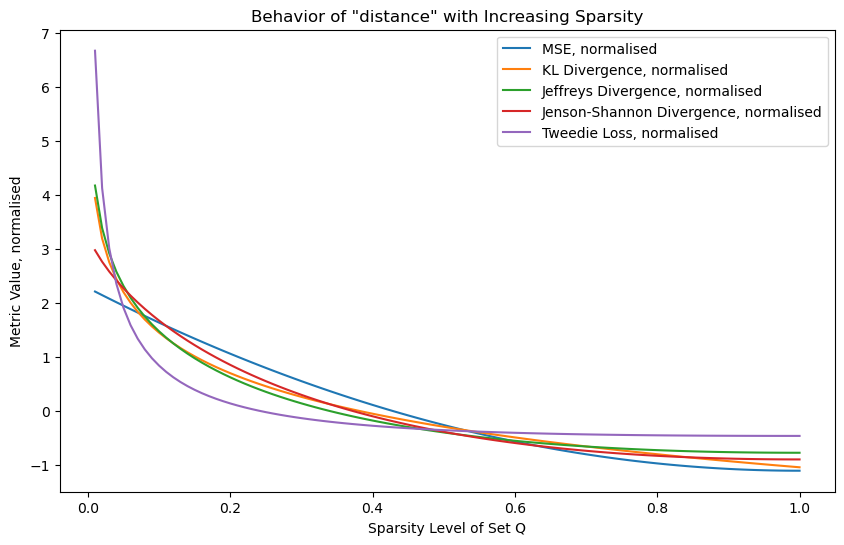

In [40]:
# Parameters
num_data_points = 100
dense_percentage = 0.95
sparse_percentage_step = 0.01

# Initialize lists to store results
sparsity_levels = []
mse_values = []
kl_values = []
j_values = []
js_values = []
w_values = []
t_values = []
g_values = []
e_values = []
s_values = []
jc_values = []
c_values = []
h_values = []
b_values = []

data_p = zero_inflated_distribution(num_data_points=num_data_points)

# Simulation loop
for sparsity in np.arange(0.01, 1+sparse_percentage_step, sparse_percentage_step):
    # Generate sparse set Q
    data_q = data_p * sparsity #+ np.random.normal(0, 1, num_data_points)**2

    # Calculate MSE
    mse = np.mean((data_p - data_q)**2)
    mse_values.append(mse)

    # Calculate KL Divergence
    kl_div = robust_kl_divergence(data_p, data_q)
    kl_values.append(kl_div)

    # Calculate J Divergence
    j_div = jeffreys_divergence(data_p, data_q)
    j_values.append(j_div)

    # Calculate JS Divergence
    js_div = jenson_shannon_divergence(data_p, data_q)
    js_values.append(js_div)

    # Calculate Wasserstein Distance
    #w_dist = wasserstein_distance(np.arange(len(data_p)), np.arange(len(data_q)), data_p, data_q)
    #w_dist = wasserstein_distance(data_p, data_q)
    #w_values.append(w_dist)


    # Calculate Tweedie Loss
    t_loss = tweedie_loss(data_p, data_q, pow = 1.5)
    t_values.append(t_loss)

    # Calculate Gini Coefficient
    #g_coeff = gini_coefficient_cdf(data_p, data_q)
    #g_values.append(g_coeff)

    # Calculate Earth Mover's Distance
    #e_dist = earth_movers_distance(data_p, data_q)
    #e_values.append(e_dist)


    # Calculate Sinkhorn Distance
    #s_dist = sinkhorn_distance(data_p, data_q)
    #s_values.append(s_dist)

    # Calculate Jaccard Similarity
    jc_sim = jaccard_similarity(set(data_p), set(data_q))
    jc_values.append(jc_sim)

    # Calculate Cosine Similarity
    c_sim = cosine_similarity(data_p, data_q)
    c_values.append(c_sim)

    # Calculate Hellinger Distance
    h_dist = hellinger_distance(data_p, data_q)
    h_values.append(h_dist)

    # Calculate Bhattacharyya Distance
    b_dist = bhattacharyya_distance(data_p, data_q)
    b_values.append(b_dist)


    # Save sparsity level for plotting
    sparsity_levels.append(sparsity)

# Plotting
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, np.array(mse_values), label='MSE')
plt.plot(sparsity_levels, np.array(kl_values), label='KL Divergence')
plt.plot(sparsity_levels, np.array(j_values), label='Jeffreys Divergence')
plt.plot(sparsity_levels, np.array(js_values), label='Jenson-Shannon Divergence')
#plt.plot(sparsity_levels, np.array(w_values), label='Wasserstein Distance')
plt.plot(sparsity_levels, np.array(t_values), label='Tweedie Loss')
#plt.plot(sparsity_levels, np.array(g_values), label='Gini Coefficient')
#plt.plot(sparsity_levels, np.array(e_values), label='Earth Mover\'s Distance')
#plt.plot(sparsity_levels, np.array(s_values), label='Sinkhorn Distance')
#plt.plot(sparsity_levels, np.array(jc_values), label='Jaccard Similarity')
#plt.plot(sparsity_levels, np.array(c_values), label='Cosine Similarity')
#plt.plot(sparsity_levels, np.array(h_values), label='Hellinger Distance')
#plt.plot(sparsity_levels, np.array(b_values), label='Bhattacharyya Distance')

plt.xlabel('Sparsity Level of Set Q')
plt.ylabel('Metric Value')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, np.log(np.array(mse_values)+1), label='MSE, logged')
plt.plot(sparsity_levels, np.log(np.array(kl_values)+1), label='KL Divergence, logged')
plt.plot(sparsity_levels, np.log(np.array(j_values)+1), label='Jeffreys Divergence, logged')
plt.plot(sparsity_levels, np.log(np.array(js_values)+1), label='Jenson-Shannon Divergence, logged')
#plt.plot(sparsity_levels, np.log(np.array(w_values)+1), label='Wasserstein Distance, logged')
plt.plot(sparsity_levels, np.log(np.array(t_values)+1), label='Tweedie Loss, logged')
#plt.plot(sparsity_levels, np.log(np.array(g_values)+1), label='Gini Coefficient, logged')
#plt.plot(sparsity_levels, np.log(np.array(e_values)+1), label='Earth Mover\'s Distance, logged')
#plt.plot(sparsity_levels, np.log(np.array(s_values)+1), label='Sinkhorn Distance, logged')
#plt.plot(sparsity_levels, np.log(np.array(jc_values)+1), label='Jaccard Similarity, logged')
#plt.plot(sparsity_levels, np.log(np.array(c_values)+1), label='Cosine Similarity, logged')
#plt.plot(sparsity_levels, np.log(np.array(h_values)+1), label='Hellinger Distance, logged')
#plt.plot(sparsity_levels, np.log(np.array(b_values)+1), label='Bhattacharyya Distance, logged')

plt.xlabel('Sparsity Level of Set Q')
plt.ylabel('Metric Value, logged')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, (np.array(mse_values)-np.array(mse_values).mean())/np.array(mse_values).std(), label='MSE, normalised')
plt.plot(sparsity_levels, (np.array(kl_values)-np.array(kl_values).mean())/np.array(kl_values).std(), label='KL Divergence, normalised')
plt.plot(sparsity_levels, (np.array(j_values)-np.array(j_values).mean())/np.array(j_values).std(), label='Jeffreys Divergence, normalised')
plt.plot(sparsity_levels, (np.array(js_values)-np.array(js_values).mean())/np.array(js_values).std(), label='Jenson-Shannon Divergence, normalised')
#plt.plot(sparsity_levels, (np.array(w_values)-np.array(w_values).mean())/np.array(w_values).std(), label='Wasserstein Distance, normalised')
plt.plot(sparsity_levels, (np.array(t_values)-np.array(t_values).mean())/np.array(t_values).std(), label='Tweedie Loss, normalised')
#plt.plot(sparsity_levels, (np.array(g_values)-np.array(g_values).mean())/np.array(g_values).std(), label='Gini Coefficient, normalised')
#plt.plot(sparsity_levels, (np.array(e_values)-np.array(e_values).mean())/np.array(e_values).std(), label='Earth Mover\'s Distance, normalised')
#plt.plot(sparsity_levels, (np.array(s_values)-np.array(s_values).mean())/np.array(s_values).std(), label='Sinkhorn Distance, normalised')
#plt.plot(sparsity_levels, (np.array(jc_values)-np.array(jc_values).mean())/np.array(jc_values).std(), label='Jaccard Similarity, normalised')  
#plt.plot(sparsity_levels, (np.array(c_values)-np.array(c_values).mean())/np.array(c_values).std(), label='Cosine Similarity, normalised')
#plt.plot(sparsity_levels, (np.array(h_values)-np.array(h_values).mean())/np.array(h_values).std(), label='Hellinger Distance, normalised')
#plt.plot(sparsity_levels, (np.array(b_values)-np.array(b_values).mean())/np.array(b_values).std(), label='Bhattacharyya Distance, normalised')

plt.xlabel('Sparsity Level of Set Q')
plt.ylabel('Metric Value, normalised')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()

plt.show()

/tmp/ipykernel_3607/1020537388.py:6: RuntimeWarning: invalid value encountered in divide
  return 0.5 * np.sum((p - q) * np.log(p / q))
/tmp/ipykernel_3607/1020537388.py:6: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * np.sum((p - q) * np.log(p / q))


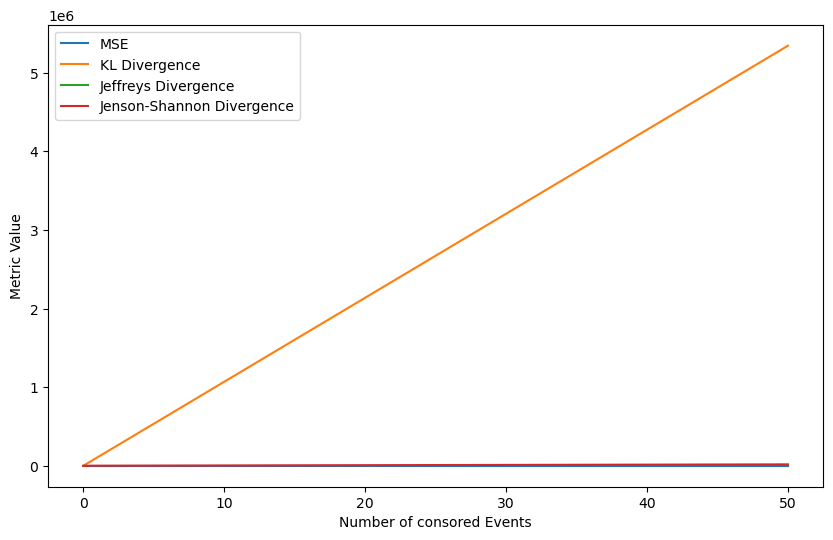

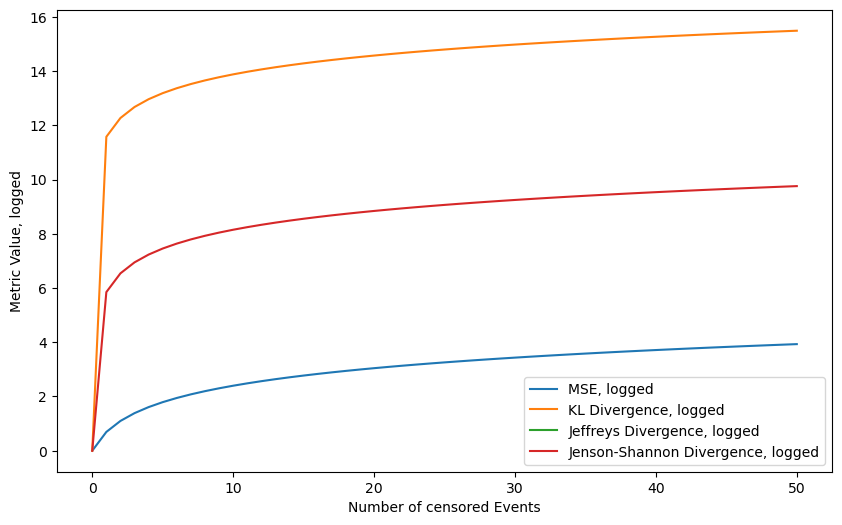

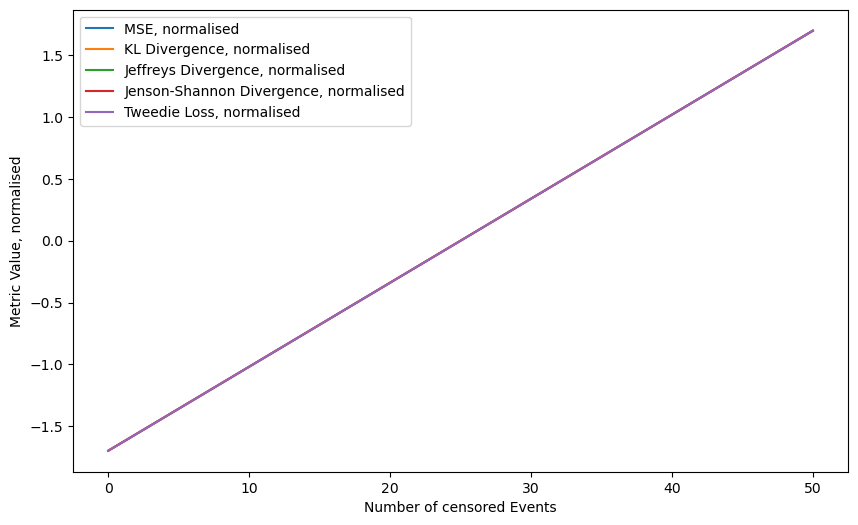

In [74]:
num_data_points = 1000000
event_size = 1000

data_p = np.zeros(num_data_points)
num_extreme_events = 50

extreme_indices = np.random.choice(num_data_points, num_extreme_events, replace=False)
data_p[extreme_indices] = event_size

data_p = np.random.permutation(data_p)

num_pred_events = []

mse_values = []
kl_values = []
j_values = []
js_values = []
w_values = []
t_values = []

# Simulate predictions
for i in range(num_extreme_events + 1):

    # copy array
    data_q = data_p.copy()

    # censor i number of extreme events
    censored_indices = np.random.choice(np.where(data_q == event_size)[0], i, replace=False)
    data_q[censored_indices] = 0

    # Calculate MSE
    mse = np.mean((data_p - data_q)**2)
    mse_values.append(mse)

    # Calculate KL Divergence
    kl_div = robust_kl_divergence(data_p, data_q)
    kl_values.append(kl_div)

    # Calculate J Divergence
    j_div = jeffreys_divergence(data_p, data_q)
    j_values.append(j_div)

    # Calculate JS Divergence
    js_div = jenson_shannon_divergence(data_p, data_q)
    js_values.append(js_div)

    # Calculate Wasserstein Distance
    #w_dist = wasserstein_distance(np.arange(len(data_p)), np.arange(len(data_q)), data_p, data_q)
    #w_values.append(w_dist)

    # Calculate Tweedie Loss
    t_loss = tweedie_loss(data_p, data_q, pow = 1.5)
    t_values.append(t_loss)

    # Save number of predicted events
    num_pred_events.append(i)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_pred_events, np.array(mse_values), label='MSE')
plt.plot(num_pred_events, np.array(kl_values), label='KL Divergence')
plt.plot(num_pred_events, np.array(j_values), label='Jeffreys Divergence')
plt.plot(num_pred_events, np.array(js_values), label='Jenson-Shannon Divergence')
#plt.plot(num_pred_events, np.array(w_values), label='Wasserstein Distance')

plt.xlabel('Number of consored Events')
plt.ylabel('Metric Value')

plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(num_pred_events, np.log(np.array(mse_values)+1), label='MSE, logged')
plt.plot(num_pred_events, np.log(np.array(kl_values)+1), label='KL Divergence, logged')
plt.plot(num_pred_events, np.log(np.array(j_values)+1), label='Jeffreys Divergence, logged')
plt.plot(num_pred_events, np.log(np.array(js_values)+1), label='Jenson-Shannon Divergence, logged')
#plt.plot(num_pred_events, np.log(np.array(w_values)+1), label='Wasserstein Distance, logged')

plt.xlabel('Number of censored Events')
plt.ylabel('Metric Value, logged')

plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_pred_events, (np.array(mse_values)-np.array(mse_values).mean())/np.array(mse_values).std(), label='MSE, normalised')
plt.plot(num_pred_events, (np.array(kl_values)-np.array(kl_values).mean())/np.array(kl_values).std(), label='KL Divergence, normalised')
plt.plot(num_pred_events, (np.array(j_values)-np.array(j_values).mean())/np.array(j_values).std(), label='Jeffreys Divergence, normalised')
plt.plot(num_pred_events, (np.array(js_values)-np.array(js_values).mean())/np.array(js_values).std(), label='Jenson-Shannon Divergence, normalised')
#plt.plot(num_pred_events, (np.array(w_values)-np.array(w_values).mean())/np.array(w_values).std(), label='Wasserstein Distance, normalised')
plt.plot(num_pred_events, (np.array(t_values)-np.array(t_values).mean())/np.array(t_values).std(), label='Tweedie Loss, normalised')


plt.xlabel('Number of censored Events')
plt.ylabel('Metric Value, normalised')

plt.legend()
plt.show()
    


/tmp/ipykernel_3607/1020537388.py:6: RuntimeWarning: invalid value encountered in divide
  return 0.5 * np.sum((p - q) * np.log(p / q))
/tmp/ipykernel_3607/1020537388.py:6: RuntimeWarning: divide by zero encountered in log
  return 0.5 * np.sum((p - q) * np.log(p / q))


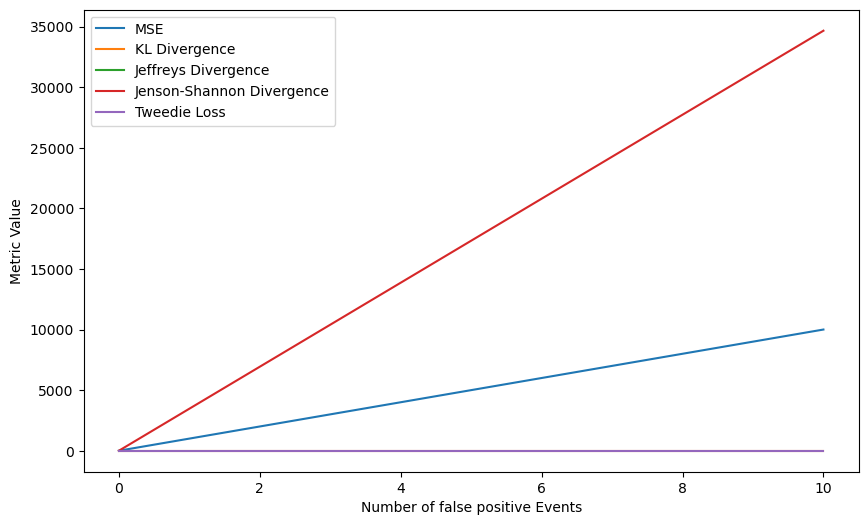

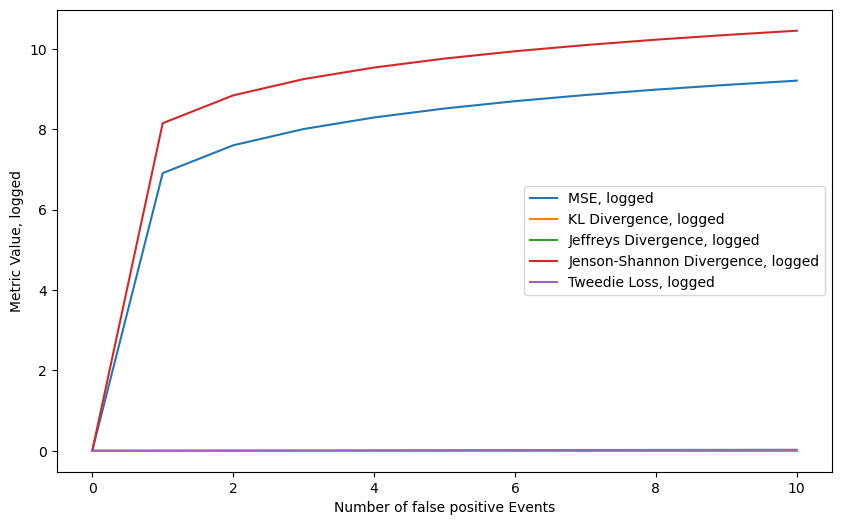

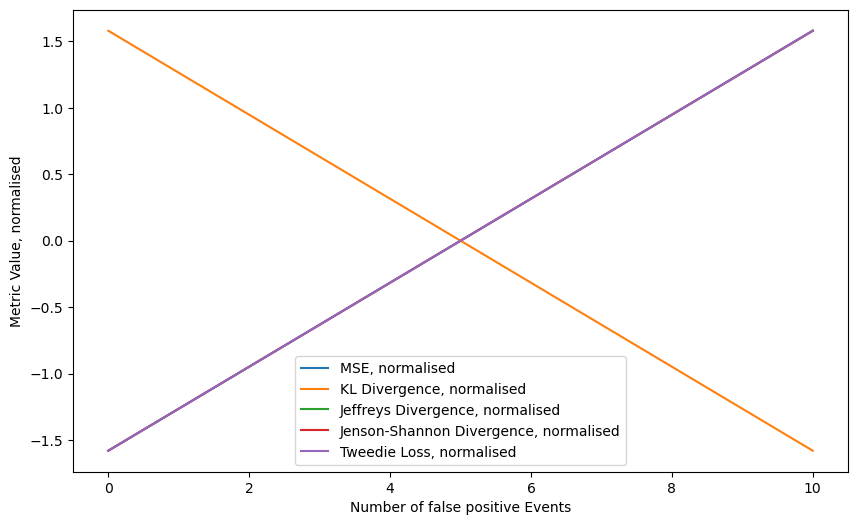

In [75]:
num_data_points = 100000
event_size = 10000

data_p = np.zeros(num_data_points)
num_extreme_events = 1

num_false_positives = 10

extreme_indices = np.random.choice(num_data_points, num_extreme_events, replace=False)
data_p[extreme_indices] = event_size

data_p = np.random.permutation(data_p)

num_pred_events = []

mse_values = []
kl_values = []
j_values = []
js_values = []
w_values = []
t_values = []

# Simulate predictions
for i in range(num_false_positives + 1):

    # copy array
    data_q = data_p.copy()

    # predict i number of false positives extreme events
    fp_indices = np.random.choice(np.where(data_q == 0)[0], i, replace=False)
    data_q[fp_indices] = event_size

    # Calculate MSE
    mse = np.mean((data_p - data_q)**2)
    mse_values.append(mse)

    # Calculate KL Divergence
    kl_div = robust_kl_divergence(data_p, data_q)
    kl_values.append(kl_div)

    # Calculate J Divergence
    j_div = jeffreys_divergence(data_p, data_q)
    j_values.append(j_div)

    # Calculate JS Divergence
    js_div = jenson_shannon_divergence(data_p, data_q)
    js_values.append(js_div)

    # calculate wasserstein distance
    #w_dist = wasserstein_distance(np.arange(len(data_p)), np.arange(len(data_q)), data_p, data_q)
    #w_values.append(w_dist)

    # Calculate Tweedie Loss
    t_loss = tweedie_loss(data_p, data_q, pow = 1.5)
    t_values.append(t_loss)

    # Save number of predicted events
    num_pred_events.append(i)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_pred_events, np.array(mse_values), label='MSE')
plt.plot(num_pred_events, np.array(kl_values), label='KL Divergence')
plt.plot(num_pred_events, np.array(j_values), label='Jeffreys Divergence')
plt.plot(num_pred_events, np.array(js_values), label='Jenson-Shannon Divergence')
#plt.plot(num_pred_events, np.array(w_values), label='Wasserstein Distance')
plt.plot(num_pred_events, np.array(t_values), label='Tweedie Loss')

plt.xlabel('Number of false positive Events')
plt.ylabel('Metric Value')

plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(num_pred_events, np.log(np.array(mse_values)+1), label='MSE, logged')
plt.plot(num_pred_events, np.log(np.array(kl_values)+1), label='KL Divergence, logged')
plt.plot(num_pred_events, np.log(np.array(j_values)+1), label='Jeffreys Divergence, logged')
plt.plot(num_pred_events, np.log(np.array(js_values)+1), label='Jenson-Shannon Divergence, logged')
# plt.plot(num_pred_events, np.log(np.array(w_values)+1), label='Wasserstein Distance, logged')
plt.plot(num_pred_events, np.log(np.array(t_values)+1), label='Tweedie Loss, logged')

plt.xlabel('Number of false positive Events')
plt.ylabel('Metric Value, logged')

plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_pred_events, (np.array(mse_values)-np.array(mse_values).mean())/np.array(mse_values).std(), label='MSE, normalised')
plt.plot(num_pred_events, (np.array(kl_values)-np.array(kl_values).mean())/np.array(kl_values).std(), label='KL Divergence, normalised')
plt.plot(num_pred_events, (np.array(j_values)-np.array(j_values).mean())/np.array(j_values).std(), label='Jeffreys Divergence, normalised')
plt.plot(num_pred_events, (np.array(js_values)-np.array(js_values).mean())/np.array(js_values).std(), label='Jenson-Shannon Divergence, normalised')
#plt.plot(num_pred_events, (np.array(w_values)-np.array(w_values).mean())/np.array(w_values).std(), label='Wasserstein Distance, normalised')
plt.plot(num_pred_events, (np.array(t_values)-np.array(t_values).mean())/np.array(t_values).std(), label='Tweedie Loss, normalised')

plt.xlabel('Number of false positive Events')
plt.ylabel('Metric Value, normalised')

plt.legend()
plt.show()


In [40]:
data_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
data_q0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
data_q1 = np.array([0, 0, 0, 0, 0, 0, 0, 0.1, 1, 0.5])
data_q2 = np.array([0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.5])
data_q3 = np.array([0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5])

print(f'Jefferys: {jeffreys_divergence(data_p, data_q0)}')
print(f'tweedie: {tweedie_loss(data_p, data_q0, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q0)**2)}')
print(f'EMD:{earth_movers_distance(data_p, data_q0)}')

print('\n')

print(f'Jefferys: {jeffreys_divergence(data_p, data_q1)}')
print(f'tweedie: {tweedie_loss(data_p, data_q1, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q1)**2)}')
print(f'EMD: {earth_movers_distance(data_p, data_q1)}')

print('\n')

print(f'Jefferys: {jeffreys_divergence(data_p, data_q2)}')
print(f'tweedie: {tweedie_loss(data_p, data_q2, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q2)**2)}')
print(f'EMD: {earth_movers_distance(data_p, data_q2)}')

print('\n')

print(f'Jefferys: {jeffreys_divergence(data_p, data_q3)}')
print(f'tweedie: {tweedie_loss(data_p, data_q3, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q3)**2)}')
print(f'EMD: {earth_movers_distance(data_p, data_q3)}')


Jefferys: 0.0
tweedie: 0.4
MSE: 0.0
EMD:0


Jefferys: 29.71158395021031
tweedie: 0.6046669094406771
MSE: 0.026000000000000002
EMD: 0.6


Jefferys: 49.82671320486001
tweedie: 0.7071067811865476
MSE: 0.075
EMD: 1.5


Jefferys: 99.65342640972003
tweedie: 1.0369411057174145e+21
MSE: 0.15
EMD: 1.0


In [51]:
data_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 10, 0])

data_q0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 10, 0])
data_q1 = np.array([0, 0, 0, 0, 0, 0, 0, 1, 10, 5])
data_q2 = np.array([0, 0, 0, 0, 0, 0, 0, 5, 5, 5])
data_q3 = np.array([0, 0, 0, 0, 0, 0, 0, 5, 0, 5])

print(f'Jefferys: {jeffreys_divergence(data_p, data_q0)}')
print(f'tweedie: {tweedie_loss(data_p, data_q0, pow=1.5)}') 
print(f'MSE: {np.mean((data_p - data_q0)**2)}') 

print('\n')

print(f'Jefferys: {jeffreys_divergence(data_p, data_q1)}')  
print(f'tweedie: {tweedie_loss(data_p, data_q1, pow=1.5)}') 
print(f'MSE: {np.mean((data_p - data_q1)**2)}') 

print('\n')

print(f'Jefferys: {jeffreys_divergence(data_p, data_q2)}')  
print(f'tweedie: {tweedie_loss(data_p, data_q2, pow=1.5)}') 
print(f'MSE: {np.mean((data_p - data_q2)**2)}') 


Jefferys: 0.0
tweedie: 1.2649110640673518
MSE: 0.0


Jefferys: 304.02359478108525
tweedie: 1.91212465956731
MSE: 2.6


Jefferys: 509.78005751357034
tweedie: 2.23606797749979
MSE: 7.5


In [154]:
data_p =  np.array([0, 0, 0, 0, 0, 0, 0, 0, 100, 0])
data_q0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 100, 0])
data_q1 = np.array([0, 0, 0, 0, 0, 0, 0, 50, 0, 50])
data_q2 = np.array([0, 0, 0, 0, 0, 0, 0, 100, 0, 100])
data_q3 = np.array([0, 0, 0, 0, 0, 0, 0, 100, 0, 0])
data_q4 = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
data_q5 = np.array([0., 0, 0, 0, 0, 0, 0, 0, 0, 0])

print(f'Target p: \t {data_p}')
print(f'prediction q: \t {data_q0}')
print(f'Jefferys: {jeffreys_divergence(data_p, data_q0)}')
print(f'Tweedie: {tweedie_loss(data_p, data_q0, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q0)**2)}')
print(f'hellinger: {hellinger_distance(data_p, data_q0)}')
print(f'Bhattacharyya: {bhattacharyya_distance(data_p, data_q0)}')


print('\n')

print(f'Target p: \t {data_p}')
print(f'prediction q: \t {data_q1}')
print(f'Jefferys: {jeffreys_divergence(data_p, data_q1)}')
print(f'Tweedie: {tweedie_loss(data_p, data_q1, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q1)**2)}')
print(f'hellinger: {hellinger_distance(data_p, data_q1)}')
print(f'Bhattacharyya: {bhattacharyya_distance(data_p, data_q1)}')

print('\n')

print(f'Target p: \t {data_p}')
print(f'prediction q: \t {data_q2}')
print(f'Jefferys: {jeffreys_divergence(data_p, data_q2)}')
print(f'Tweedie: {tweedie_loss(data_p, data_q2, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q2)**2)}')
print(f'hellinger: {hellinger_distance(data_p, data_q2)}')
print(f'Bhattacharyya: {bhattacharyya_distance(data_p, data_q2)}')
      
print('\n')

print(f'Target p: \t {data_p}')
print(f'prediction q: \t {data_q3}')
print(f'Jefferys: {jeffreys_divergence(data_p, data_q3)}')
print(f'Tweedie: {tweedie_loss(data_p, data_q3, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q3)**2)}')
print(f'hellinger: {hellinger_distance(data_p, data_q3)}')
print(f'Bhattacharyya: {bhattacharyya_distance(data_p, data_q3)}')

print('\n')

print(f'Target p: \t {data_p}')
print(f'prediction q: \t {data_q4}')
print(f'Jefferys: {jeffreys_divergence(data_p, data_q4)}')
print(f'Tweedie: {tweedie_loss(data_p, data_q4, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q4)**2)}')
print(f'hellinger: {hellinger_distance(data_p, data_q4)}')
print(f'Bhattacharyya: {bhattacharyya_distance(data_p, data_q4)}')

print('\n')

print(f'Target p: \t {data_p}')
print(f'prediction q: \t {data_q5}')
print(f'Jefferys: {jeffreys_divergence(data_p, data_q5)}')
print(f'Tweedie: {tweedie_loss(data_p, data_q5, pow=1.5)}')
print(f'MSE: {np.mean((data_p - data_q5)**2)}')
print(f'hellinger: {hellinger_distance(data_p, data_q5)}')
print(f'Bhattacharyya: {bhattacharyya_distance(data_p, data_q5)}')


Target p: 	 [  0   0   0   0   0   0   0   0 100   0]
prediction q: 	 [  0   0   0   0   0   0   0   0 100   0]
Jefferys: 0.0
Tweedie: 4.0
MSE: 0.0
hellinger: 0.0
Bhattacharyya: -4.605170185988092


Target p: 	 [  0   0   0   0   0   0   0   0 100   0]
prediction q: 	 [ 0  0  0  0  0  0  0 50  0 50]
Jefferys: 10425.859659570811
Tweedie: 1.0369411057174144e+23
MSE: 1500.0
hellinger: 10.0
Bhattacharyya: 46.81604131998641


Target p: 	 [  0   0   0   0   0   0   0   0 100   0]
prediction q: 	 [  0   0   0   0   0   0   0 100   0 100]
Jefferys: 15690.775527898211
Tweedie: 1.0369411057174144e+23
MSE: 3000.0
hellinger: 12.24744871391589
Bhattacharyya: 46.59880261833784


Target p: 	 [  0   0   0   0   0   0   0   0 100   0]
prediction q: 	 [  0   0   0   0   0   0   0 100   0   0]
Jefferys: 10460.517018598808
Tweedie: 1.0369411057174144e+23
MSE: 2000.0
hellinger: 10.0
Bhattacharyya: 47.00426772644601


Target p: 	 [  0   0   0   0   0   0   0   0 100   0]
prediction q: 	 [10 10 10 10 10 10 1

In [56]:
num_data_points = 100000
event_size = 10

data_p = np.zeros(num_data_points)
num_extreme_events = 5

extreme_indices = np.random.choice(num_data_points, num_extreme_events, replace=False)
data_p[extreme_indices] = event_size

data_p = np.random.permutation(data_p)
data_p

array([0., 0., 0., ..., 0., 0., 0.])

In [2]:
list_ = [np.float64, np.float32, np.float16, np.complex64, np.complex128, np.int64, np.int32, np.int16, np.int8, np.uint8]

for i in list_:

    array  = np.random.randint(0, 256, [10,10,3]).astype(i)
    tensor = transforms.ToTensor()(array)
    print(tensor)

tensor([[[216., 107., 132.,   2.,   6.,  66.,  40., 109.,  91., 150.],
         [240.,  66.,   6., 167., 240., 168., 182., 102., 215.,  11.],
         [  1., 210., 110., 133., 111.,   4., 138.,   1., 186., 171.],
         [249.,  68., 117., 166.,  93., 199., 105.,  12.,   0.,  36.],
         [ 87.,  37.,  92.,  59., 237., 119., 224.,  79.,   9., 210.],
         [ 42.,  67., 164.,  37.,  95.,  67.,  22., 209., 161.,  18.],
         [ 83., 207., 132., 178., 192., 132., 251.,  13.,  29.,  12.],
         [170., 234.,  20.,  78.,  37.,  35.,   3.,  26., 186., 134.],
         [ 61., 140.,  32.,  64.,  57., 172.,  54., 105., 155., 146.],
         [233., 200., 221.,  97.,  40., 229., 157.,  26., 197., 134.]],

        [[209.,  81., 255.,  54., 232., 187.,  50., 214., 140., 109.],
         [218.,  32., 147.,  97., 140.,  24., 153.,  57., 179., 204.],
         [118.,   5., 117.,  11., 169., 109., 122.,  14., 229., 104.],
         [ 93.,   5.,  42.,  45., 120., 243., 246., 235.,  63., 162.],
    

In [13]:
array  = np.random.randint(0, 256, [10,10,3])
transforms.ToTensor()(array)

tensor([[[ 95,  99, 225,  96,   5, 215, 175,  77, 208,  55],
         [208,  45,  92, 166,  36, 192, 141, 205, 255,  19],
         [229, 127, 241, 178, 110, 246,  53, 120, 234,  96],
         [ 71, 203, 170, 231, 128,  66, 109,  52, 105, 228],
         [ 98, 141, 136, 180,  14, 142,  71, 156, 145, 134],
         [ 64,  14, 210, 188,  64, 217,  25, 184, 190,  37],
         [109, 246,  39, 255, 124,  82, 118, 227,  78, 152],
         [ 61, 161,   5,  74,  78,  61, 176, 139,  22,  17],
         [219, 194, 125, 112, 134,  84, 180, 205, 196, 170],
         [142,  50, 213, 208,   2, 134, 207, 143,  19,  27]],

        [[213, 129, 164, 181, 129, 223, 124,  46, 212,  52],
         [ 79,  78,   0, 199, 113, 131,  68, 127, 169, 210],
         [ 14,  93, 194, 159,  79,  13, 232,  57,  87,  31],
         [255, 104, 116, 167, 125,  91,  49, 126, 222, 214],
         [232, 131,   0,  83,  83, 217, 182, 102,  79,  38],
         [  4,  94,  69, 181, 175,  81, 219,  14,  97, 174],
         [ 45, 200, 11

In [4]:
new_tensor = transforms.ToTensor()(array)
new_tensor

tensor([[[ 37, 161, 146,  41, 107, 166, 113, 189, 234,  34],
         [ 87,  30, 240,  93, 112,  49, 144,  16,  30, 223],
         [228, 209, 178,  52,  56, 246, 206,  90, 234, 172],
         [221, 112, 103, 117, 188, 211, 241, 238,  47,  68],
         [ 90,  97,  14,  63,  22,  26,  37,  75, 133,  29],
         [172, 229, 103,  14,  14, 251,  36, 187, 147, 156],
         [ 26,  19, 224, 253, 233,  43,  73, 179,  87,  44],
         [ 43, 224, 182, 105, 162,  13, 108, 234,  36, 243],
         [  9,  57, 174, 219, 135,  36,  90, 125,   5, 233],
         [193,  16, 221, 250, 214, 215,  49, 184,  36, 240]],

        [[ 96,   8,  95, 244,  21, 214, 255, 219,  10,   0],
         [108,  59,  27, 177, 141, 122, 150, 155, 199, 236],
         [213, 186, 225, 113, 152, 221,  75, 157,  28, 206],
         [249, 152,  32,   9, 218, 206, 195,  48,  30, 113],
         [ 65, 159, 112,  19, 205,  63,  65, 250, 219, 174],
         [ 38, 243,  67,  50, 127, 249,  90, 157, 193, 169],
         [169, 158, 25

In [5]:
def terning(max, antal, exprmnt):

    """
    Max er den højeste værdi terningen kan vise, dvs. ternings antal sider.
    Antal er antallet af terninger der kastes.
    Exprmnt er antallet af eksperimenter der udføres.
    """

    result = np.random.randint(1, max+1, (antal, exprmnt))

    return result

In [6]:
sides = [4,6,8,10,12,20,100]

dict = {}

for s in sides:

    t = terning(s, 3, 1000)
    t_sum = np.sum(t, axis=0)

    dict[s] = t_sum


In [7]:
dict[20]

array([20, 26, 22, 21, 30, 35, 38, 31, 45, 19, 25, 31, 40, 34, 29, 47, 36,
       27, 38, 27, 44, 25, 36, 29, 20, 44, 47, 31, 28, 21, 36, 26, 54, 40,
       40, 21, 17, 53, 25, 32, 33, 30, 32, 29, 25, 33, 33, 13, 34, 31, 25,
       41, 31, 34, 41, 24, 20, 46, 25, 41, 31, 47, 25, 43, 36, 32, 41, 20,
       33, 31, 33, 26, 44, 22, 28, 53, 47, 48, 35, 31, 37, 42, 38, 22, 25,
       40, 17, 25, 37, 12, 24, 10, 36, 44, 17, 28, 49, 35, 13, 26, 34, 47,
       16, 40, 37, 48, 49, 28, 32, 29, 32, 39, 20, 22, 25, 44,  6, 40, 39,
       21, 42, 13, 28, 29, 17, 50, 25, 43, 46, 39, 15, 34, 33, 41, 15, 26,
       42, 30, 15, 39, 28, 28, 19, 24, 10, 32, 24, 34, 59, 41, 34, 43, 40,
       37, 19, 26, 17, 25, 24, 56, 30, 44, 49, 23, 33, 35, 23, 32, 21, 23,
       24, 29, 28, 21, 50, 33, 55, 49, 43, 43, 33, 25, 23, 41, 27, 22, 36,
       46, 24, 44, 45, 32, 30, 18, 47, 40, 42, 30, 21, 35, 13, 32, 23, 32,
       28, 23, 28, 29, 51, 45, 25, 37, 22, 25, 37, 43, 52, 30, 21, 29,  3,
       21, 41, 25, 23, 31

In [32]:
t = terning(6, 2, 10)
t_mean = np.mean(t, axis=1)

t_mean

array([3.8, 3.2])

In [34]:
terning(6, 2, 10).sum(axis=0)

array([ 6,  8,  4, 11,  6, 12,  6,  2,  7,  3])

In [1]:
import sys
import numpy as np
import torch
from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss


import torch.nn as nn
import torch.nn.functional as F


from torch.autograd import Variable

# https://d2l.ai/chapter_recurrent-modern/gru.html

import matplotlib.pyplot as plt


sys.path.insert(0, "/home/simon/Documents/scripts/conflictNet/src/utils")
from warmup_decay_lr_scheduler import WarmupDecayLearningRateScheduler

In [33]:
torch.zeros((1, 32, 32, 32), dtype=torch.float32).shape

torch.Size([1, 32, 32, 32])

In [48]:
h = torch.zeros((1, 32, 32, 32), dtype=torch.float32)

h[:, :4, :, :] = 1
h[:, 4:8, :, :] = 2
h[:, 8:12, :, :] = 3
h[:, 12:16, :, :] = 4
h[:, 16:20, :, :] = 5
h[:, 20:24, :, :] = 6  
h[:, 24:28, :, :] = 7 
h[:, 28:32, :, :] = 8


In [52]:
split_8_ways = int(h.shape[1] / 8) 

hs1, hs2, hs3, hs4, hl1, hl2, hl3, hl4 = torch.split(h, split_8_ways, dim=1) 
new_h = torch.cat([hs1, hs2, hs3, hs4, hl1, hl2, hl3, hl4], dim=1)





print(new_h[:, :4, :, :].mean())
print(new_h[:, 4:8, :, :].mean())
print(new_h[:, 8:12, :, :].mean())
print(new_h[:, 12:16, :, :].mean())
print(new_h[:, 16:20, :, :].mean())
print(new_h[:, 20:24, :, :].mean())
print(new_h[:, 24:28, :, :].mean())
print(new_h[:, 28:32, :, :].mean())

tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(5.)
tensor(6.)
tensor(7.)
tensor(8.)


In [44]:
hs4

tensor([[[[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]],

         [[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]],

         [[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]],

         [[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          

In [3]:
h = torch.zeros((1, 32, 32, 32), dtype=torch.float32)

h[:, :8, :, :] += 1  
h[:, 8:16, :, :] += 2 
h[:, 16:24, :, :] += 3
h[:, 24:, :, :] += 4

h_frozen = h.clone()
h_new = h.clone() * -1

In [4]:
split_four_ways = int(h_frozen.shape[1] / 4) 

hs_1_frozen, hs_2_frozen, hl_1_frozen, hl_2_frozen = torch.split(h_frozen, split_four_ways, dim=1)
hs_1_new, hs_2_new, hl_1_new, hl_2_new = torch.split(h_new, split_four_ways, dim=1) 

pairs = [(hs_1_frozen, hs_1_new), (hs_2_frozen, hs_2_new), (hl_1_frozen, hl_1_new), (hl_2_frozen, hl_2_new)]

h_mix = torch.cat([pair[0] if torch.rand(1) < 0.5 else pair[1] for pair in pairs], dim=1)



# ----------------------------


print(h_mix[:, :8, :, :].mean())
print(h_mix[:, 8:16, :, :].mean())
print(h_mix[:, 16:24, :, :].mean())
print(h_mix[:, 24:, :, :].mean())

tensor(-1.)
tensor(2.)
tensor(3.)
tensor(-4.)


In [5]:
print(h_mix[:, :8, :, :].mean())
print(h_mix[:, 8:16, :, :].mean())
print(h_mix[:, 16:24, :, :].mean())
print(h_mix[:, 24:, :, :].mean())

tensor(-1.)
tensor(2.)
tensor(3.)
tensor(-4.)


In [6]:
h_mix[:, 24:, :, :]

tensor([[[[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          ...,
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.]],

         [[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          ...,
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.]],

         [[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          ...,
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.]],

         ...,

         [[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -

In [91]:
selected_tensors = torch.cat(selected_tensors, dim=1)

In [92]:
selected_tensors.shape

torch.Size([1, 32, 32, 32])

In [66]:
split_hs_hl = int(h.shape[1] / 4)  # Half of the second dimension, which is channels

# Split the tensor along dimension 1 into 4 parts
hs_1, hs_2, hl_1, hl_2 = torch.split(h, split_hs_hl, dim=1)

# The result will be a tuple of four tensors
# hs_1, hs_2, hl_1, hl_2 = split_tensors_hs_hl

In [67]:
print(hs_1.shape)
print(hs_2.shape)
print(hl_1.shape)
print(hl_2.shape)

torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])


In [68]:
print(hs_1.mean())
print(hs_2.mean())
print(hl_1.mean())
print(hl_2.mean())

tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)


In [49]:
split_hs_hl = int(h.shape[1]/2) # half of the second dimension wich is channels

# Split the tensor along dimension 1
split_tensors_hs_hl = torch.split(h, split_hs_hl, dim=1)

# The result will be a tuple of two tensors
hs, hl = split_tensors_hs_hl

# Second split to get the two tensors that make up hs and hl
split_1_2 = int(split_hs_hl/2) # half of the second dimension wich is channels

split_tensors_hs1_hs2 = torch.split(hs, split_1_2, dim=1)

split_tensors_hl1_hl2 = torch.split(hl, split_1_2, dim=1)

hs_1, hs_2 = split_tensors_hs1_hs2
hl_1, hl_2 = split_tensors_hl1_hl2





In [ ]:
# Assuming you have h_a and h_b tensors

# Create lists of tensors from h_a and h_b
tensors_a = [hs_1a, hs_2a, hl_1a, hl_2a]
tensors_b = [hs_1b, hs_2b, hl_1b, hl_2b]

# Shuffle the order of selection
random.shuffle(tensors_a)
random.shuffle(tensors_b)

# Combine tensors from a and b
result_tensors = [tensors_a.pop() if random.choice([True, False]) else tensors_b.pop() for _ in range(4)]


In [50]:
print(hs_1.shape)
print(hs_2.shape)
print(hl_1.shape)
print(hl_2.shape)

torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])


In [ ]:
split = int(h_tt.shape[1]/2) # split h_tt into hs_tt and hl_tt and save hl_tt as the forzen cell state/long term memory. Call it hl_frozen. Half of the second dimension which is channels.
_, hl_frozen = torch.split(h_tt, split, dim=1)
t1_pred, t1_pred_class, h_tt = model(t0, h_tt) 
hs, _ = torch.split(h_tt, split, dim=1) # Again split the h_tt into hs_tt and hl_tt. But discard the hl_tt
h_tt = torch.cat((hs, hl_frozen), dim=1) # Concatenate the frozen cell state/long term memory (hl_frozen) with the new hidden state/short term memory. this is the new h_tt


In [41]:
for i in range(10):

    print(['j','a','e'][np.random.choice(3)])

j
j
j
e
a
e
j
e
e
e


In [1]:
def terning(max, antal, exprmnt):

    """
    Max er den højeste værdi terningen kan vise, dvs. ternings antal sider.
    Antal er antallet af terninger der kastes.
    Exprmnt er antallet af eksperimenter der udføres.
    """

    result = np.random.randint(1, max+1, (antal, exprmnt))

    return result

In [12]:
terning?

Signature: terning(max, antal, exprmnt)
Docstring:
Max er den højeste værdi terningen kan vise, dvs. ternings antal sider.
Antal er antallet af terninger der kastes.
exprmnt er antallet af eksperimenter der udføres.
File:      /tmp/ipykernel_51386/728988540.py
Type:      function


In [13]:
to_d_6_100 =  terning(6, 2, 100)
print(to_d_6_100)

[[3 2 2 5 4 3 3 4 4 3 2 2 4 5 4 3 3 4 5 4 1 5 5 2 4 5 3 3 3 4 2 4 4 5 2 3
  5 1 3 1 1 5 1 1 1 4 4 3 4 5 2 5 4 2 1 1 4 3 4 3 4 1 2 4 3 4 1 5 4 5 1 2
  2 4 3 1 2 4 4 5 2 2 5 3 4 1 1 2 4 4 3 2 4 3 4 5 5 4 1 4]
 [2 5 4 3 3 5 1 1 5 2 2 5 4 5 3 4 5 2 4 1 3 4 3 2 3 5 5 1 1 2 4 1 5 5 3 4
  1 3 3 2 2 2 3 4 1 2 1 3 5 3 4 1 1 4 5 1 3 5 1 1 5 5 3 5 2 3 2 1 3 2 5 1
  5 2 4 2 4 2 2 4 5 2 1 2 1 4 5 4 2 5 4 1 4 5 5 1 5 4 2 2]]


In [14]:
dmg = to_d_6_100.sum(0)
dmg

array([ 5,  7,  6,  8,  7,  8,  4,  5,  9,  5,  4,  7,  8, 10,  7,  7,  8,
        6,  9,  5,  4,  9,  8,  4,  7, 10,  8,  4,  4,  6,  6,  5,  9, 10,
        5,  7,  6,  4,  6,  3,  3,  7,  4,  5,  2,  6,  5,  6,  9,  8,  6,
        6,  5,  6,  6,  2,  7,  8,  5,  4,  9,  6,  5,  9,  5,  7,  3,  6,
        7,  7,  6,  3,  7,  6,  7,  3,  6,  6,  6,  9,  7,  4,  6,  5,  5,
        5,  6,  6,  6,  9,  7,  3,  8,  8,  9,  6, 10,  8,  3,  6])

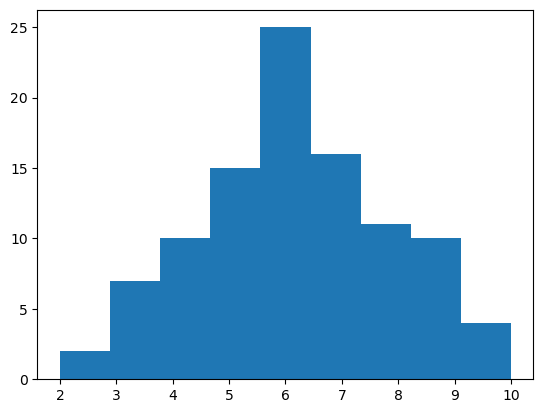

In [15]:
plt.hist(dmg, bins=9)
plt.show()

In [53]:
# full_vol = torch.zeros((300, 256, 256, 4), dtype=torch.float32) #  [N, C, D, H, W]

full_vol = torch.randn((300, 256, 256, 4), dtype=torch.float32)**2 #  [N, C, D, H, W]


full_vol[:, :, :, 0] += 99  
full_vol[:, :, :, 1] += 1 
full_vol[:, :, :, 2] += 2
full_vol[:, :, :, 3] += 3

full_vol = torch.log(full_vol+1)

In [54]:
full_vol

tensor([[[[4.6071, 1.9131, 2.0007, 1.3871],
          [4.6168, 0.8975, 1.2306, 1.4198],
          [4.6066, 0.9201, 1.2958, 1.4596],
          ...,
          [4.6072, 0.9943, 1.0989, 1.3930],
          [4.6068, 1.0841, 1.2980, 1.4747],
          [4.6066, 0.9120, 1.1755, 1.5574]],

         [[4.6068, 1.8559, 1.1686, 1.4734],
          [4.6082, 1.0379, 1.5292, 1.5191],
          [4.6067, 0.7474, 1.1406, 1.4072],
          ...,
          [4.6149, 1.2681, 1.1181, 1.4900],
          [4.6069, 0.8128, 1.2314, 1.5005],
          [4.6063, 1.0456, 1.1055, 1.3885]],

         [[4.6300, 0.9509, 1.1051, 1.5466],
          [4.6055, 0.7621, 1.2789, 1.6862],
          [4.6052, 1.9078, 1.0990, 1.4118],
          ...,
          [4.6409, 1.1312, 1.4496, 1.3982],
          [4.6087, 0.7045, 1.1326, 1.7147],
          [4.6086, 1.1747, 2.1570, 1.5328]],

         ...,

         [[4.6142, 0.6940, 1.1042, 1.6339],
          [4.6281, 0.6940, 1.3758, 1.4216],
          [4.6052, 1.1891, 1.2322, 1.3966],
          

In [55]:
config = {
    'first_feature_idx': 1,
    'input_channels': 3}


a = 0
b = 1

In [58]:
def norm_features(full_vol ,config, un_log = True, a = 0, b = 1) -> np.ndarray:

    """
    Normalize the features of the volume. One by one to the range [a, b]. 
    """
    

    first_feature_idx = config['first_feature_idx'] #config.first_feature_idx
    last_feature_idx = first_feature_idx + config['input_channels'] - 1 #config.first_feature_idx + config.input_channels - 1


    for i in range(first_feature_idx, last_feature_idx + 1):

        feature = full_vol[:, :, :, i] 

        # if config.un_log:
        #     feature = torch.exp(feature) - 1

        feature_max = feature.max() # could make sure that we are not using information from the future.... But this is not a big deal... 
        feature_min = 0 #full_vol[:, :, :, i].min()

        feature_norm = (b-a)*(feature - feature_min)/(feature_max-feature_min)+a

        full_vol[:,:,:,i] = feature_norm

    return full_vol

In [ ]:
def norm_channels(tensor, config, un_log = True, a = 0, b = 1) -> torch.Tensor: # not reall a tensor now but an array...

    """
    Normalizes the feature channels for a tensor  to the range [a, b].
    Defualt is [-1, 1] to match the batch norm layers.
    The input tensor is expected to have the shape [N, C, D, H, W]
    Where N is the batch size, C is the number of timesteps, D is the features, H is the height and W is the width.   
    """

    # if un_log:
    #     tensor = torch.exp(tensor)

    first_feature_idx = config['first_feature_idx'] #config.first_feature_idx
    last_feature_idx = first_feature_idx + config['input_channels'] - 1 #config.first_feature_idx + config.input_channels - 1

    min_list = []
    max_list = []

    for i in range(first_feature_idx, last_feature_idx + 1):
        #min_list.append(np.min(tensor[ :, :, :, i]))
        max_list.append(np.max(tensor[ :, :, :, i]))

    # norm_tensor = (b-a)*(tensor - tensor.min())/(tensor.max()-tensor.min())+a

    norm_tensor = (b-a)*(tensor - 0)/(8-0)+a # 8 just hardcoded until later....

In [11]:
def norm_channels(tensor, config, pre_logged = True, a = -1, b = 1) -> torch.Tensor:

    """
    Normalizes the feature channels for a tensor  to the range [a, b].
    Defualt is [-1, 1] to match the batch norm layers.
    The input tensor is expected to have the shape [N, C, D, H, W]
    Where N is the batch size, C is the number of timesteps, D is the features, H is the height and W is the width.   
    """

    if pre_logged:
        tensor = torch.exp(tensor)

    first_feature_idx = config['first_feature_idx'] #config.first_feature_idx
    last_feature_idx = config['first_feature_idx'] + config['input_channels'] - 1 #config.first_feature_idx + config.input_channels - 1

    min_list = []
    max_list = []

    for i in range(first_feature_idx, last_feature_idx + 1):
        min_list.append(torch.min(tensor[:, :, i, :, :]))
        max_list.append(torch.max(tensor[:, :, i, :, :]))

    norm_tensor = (b-a)*(tensor - tensor.min())/(tensor.max()-tensor.min())+a
    
    return norm_tensor


In [12]:
logged_norm = norm_channels(log_full_vol, config, pre_logged = True, a = 0, b = 1)

In [13]:
print(logged_norm.max())
print(logged_norm.min())

tensor(1.)
tensor(0.)


In [5]:
norm_sub_vol = norm_channels(sub_vol, config, pre_logged = True)

print(norm_sub_vol.max())
print(norm_sub_vol.min())

tensor(1.)
tensor(-1.)


In [ ]:
def norm(x, a = 0, b = 1):

    """Return a normalized x in range [a:b]. Default is [0:1]"""
    x_norm = (b-a)*(x - x.min())/(x.max()-x.min())+a
    return(x_norm)

In [ ]:
config.first_feature_idx

In [ ]:
# Assuming you have a tensor with dimensions H x W x C
tensor = torch.rand(180, 180, 3)  # Replace this with your actual tensor

# Calculate maximum and minimum values for each channel (C dimension)
max_values, _ = torch.max(tensor, dim=(0, 1))  # Max values for each channel
min_values, _ = torch.min(tensor, dim=(0, 1))  # Min values for each channel


In [ ]:
max_values.shape

In [ ]:
batch_size = 3
seq_len = 300
window_size = 180
 

Q  =  torch.randn(batch_size, seq_len, window_size, window_size)
Q.shape

In [ ]:
Q = torch.tensor([[[1,1,1],[1,1,1],[1,1,1]],[[2,2,2],[2,2,2],[2,2,2]],[[3,3,3],[3,3,3],[3,3,3]]])

In [ ]:
torch.max(Q, dim=2)

In [ ]:
torhc.max(Q, dim)

In [ ]:
min_max_values

In [ ]:
WarmupDecayLearningRateScheduler?

In [ ]:
lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.001
optimizer = torch.optim.Adam(model,lr = LR)

samples = 10000


# ---------------------------

scheduler = WarmupDecayLearningRateScheduler(optimizer, 32*32*3, 100)
for epoch in range(samples):
    data_size = 40
    for i in range(data_size):
        optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.plot(range(samples),lr_list,color = 'r')
plt.hlines(y=0,xmin=0, xmax=samples,  colors = "c",linestyles = "dashed")
plt.show()

In [ ]:
lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.001
optimizer = torch.optim.Adam(model,lr = LR)

samples = 300


# ---------------------------

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = samples*0.04, eta_min = 0.00005)
for epoch in range(samples):
    data_size = 40
    for i in range(data_size):
        optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.plot(range(samples),lr_list,color = 'r')
plt.hlines(y=0,xmin=0, xmax=samples,  colors = "c",linestyles = "dashed")
plt.show()

In [ ]:
batch_size = 3
seq_len = 300
d_model = 1000
 

Q  =  torch.randn(batch_size, seq_len, d_model)
print(Q.shape)



n_head = 2

Q = Q.view(batch_size, seq_len, n_head, -1).permute(0, 2, 1, 3)
print(Q.shape)



In [ ]:
np.exp(np.log(9))

In [ ]:

torch.exp(torch.log(torch.tensor(9.0)+1))-1

In [ ]:
def small_test(x,y) -> torch.Tensor:
    return x+y

In [ ]:
z = small_test(1, 2)

type(z)

In [ ]:
small_test?

In [ ]:
# Create a tensor of size [1, 10, 32, 32]
hc = torch.randn(1, 10, 32, 32)

split = int(hc.shape[1]/2) # half of the second dimension wich is channels

# Split the tensor along dimension 1
split_tensors = torch.split(hc, split, dim=1)

# The result will be a tuple of two tensors
h0, c0 = split_tensors

# Print the sizes of the split tensors
print(h.size())  # torch.Size([1, 5, 32, 32])
print(c.size())  # torch.Size([1, 5, 32, 32])

In [ ]:
c0 = c0 * 0 

In [ ]:
hc = torch.cat([h0, c0], 1) 

In [ ]:
# Split the tensor along dimension 1
split_tensors = torch.split(hc, split, dim=1)

# The result will be a tuple of two tensors
h1, c1 = split_tensors

# Print the sizes of the split tensors
print(h1.size())  # torch.Size([1, 5, 32, 32])
print(c1.size())  # torch.Size([1, 5, 32, 32])

In [ ]:
h0 == h1

In [ ]:
h.shape

In [ ]:
tensor2.shape

In [ ]:
hc = torch.zeros((1,10,32,32), dtype= torch.float64)



In [ ]:
input_tensor.shape

In [ ]:
hc.shape

In [ ]:
channels = hc.shape[1]
split = int(channels/2)

# Split the tensor along dimension 1
split_tensors = torch.split(hc, split, dim=1)

c.shape, h.shape

In [ ]:
channels

In [ ]:
kernel_size = 3
padding = kernel_size // 2

In [ ]:
padding

In [ ]:
base = 10
dim = 2

cube = base**dim

print(np.sqrt(cube)) # assuming dim is 2
print(np.log10(cube)) # assuming base is 10

In [ ]:
lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.001
optimizer = torch.optim.Adam(model,lr = LR)

samples = 300


# ---------------------------

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = samples*0.04, eta_min = 0.00005)
for epoch in range(samples):
    data_size = 40
    for i in range(data_size):
        optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.plot(range(samples),lr_list,color = 'r')
plt.hlines(y=0,xmin=0, xmax=samples,  colors = "c",linestyles = "dashed")
plt.show()

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        padding = kernel_size // 2

        # Input gate
        self.Wxi = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Whi = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)
        self.Wxf = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Whf = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)
        self.Wxc = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Whc = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)
        self.Wxo = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Who = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)

    def forward(self, x, hidden):
        h, c = hidden

        # Input gate
        i_t = torch.sigmoid(self.Wxi(x) + self.Whi(h))
        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x) + self.Whf(h))
        # Cell state
        c_tilde = torch.tanh(self.Wxc(x) + self.Whc(h))
        c = f_t * c + i_t * c_tilde
        # Output gate
        o_t = torch.sigmoid(self.Wxo(x) + self.Who(h))
        h = o_t * torch.tanh(c)

        return h, c

# Example usage
input_channels = 3
hidden_channels = 10
kernel_size = 3
cell = ConvLSTMCell(input_channels, hidden_channels, kernel_size)
x = torch.randn(1, input_channels, 32, 32)
hidden_state = (torch.randn(1, hidden_channels, 32, 32), torch.randn(1, hidden_channels, 32, 32))

output, new_hidden_state = cell(x, hidden_state)


In [ ]:
output.shape

In [ ]:
#input = np.random.randint(1,21,[5,5,5])
#input = torch.from_numpy(X)

B = 1
C = 3
H = 5
W = 5 

input = torch.randn(1,3,3,5,5)
m = nn.Linear(5, 5, bias=False)
output = m(input)
print(output.size())



In [ ]:
input

In [ ]:
output

In [ ]:
input

In [ ]:
m = nn.Linear((3,5), (3,5))
#input = torch.randn(128, 20)
output = m(input)
print(output.size())

In [ ]:
X = np.random.randint(1,21,[5,5,5])
X_tensor = torch.tensor(X)

In [ ]:
X_tensor = torch.tensor(X)

In [ ]:
X_tensor

In [ ]:
criterion_reg = nn.MSELoss()
criterion_class = nn.BCELoss()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(
            self,
            weight=None,
            gamma=2.0,
            reduction='mean'
    ):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = torch.sigmoid(input_tensor)
        prob = torch.exp(log_prob)
        
        term = ((1.0 - prob) ** self.gamma) * log_prob
        return F.nll_loss(term, target_tensor)
        
        #return F.nll_loss(term, target_tensor, weight=self.weight, reduction=self.reduction)
        

In [ ]:
class FocalLoss01(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss01, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()
        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1,2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        # compute the negative likelyhood
        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss02(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss02, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        # if input.dim()>2:
        #     input = input.contiguous().view(input.size(0), input.size(1), -1)
        #     input = input.transpose(1,2)
        #     input = input.contiguous().view(-1, input.size(2)).squeeze()
        # if target.dim()==4:
        #     target = target.contiguous().view(target.size(0), target.size(1), -1)
        #     target = target.transpose(1,2)
        #     target = target.contiguous().view(-1, target.size(2)).squeeze()
        # elif target.dim()==3:
        #     target = target.view(-1)
        # else:
        #     target = target.view(-1, 1)

        input, target = input.unsqueeze(0), target.unsqueeze(0)

        # compute.unsqueeze(0)F.cross_entropy(input, target)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss03(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss03, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)

        # compute.unsqueeze(0)F.cross_entropy(input, target)
        p = 1/(1+np.exp(-input))
        loss = -( self.alpha*target + (1-self.alpha)*(1-target) ) * (( 1 - ( target*p + (1-target)*(1-p)) )**self.gamma) * ( target*np.log(p)+(1-target)*np.log(1-p) )

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss04(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss04, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        
        input, target = input.unsqueeze(0), target.unsqueeze(0)

        loss = -(target * np.log(input) + (1-target) * np.log(1-input)) #BCE

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss05(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss05, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        logpt = (target * np.log(input) + (1-target) * np.log(1-input))
        loss = -self.alpha * ((1-np.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
# BEST!!!

class FocalLoss05(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss05, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        logpt = (target * np.log(input) + (1-target) * np.log(1-input))
        loss = -self.alpha * ((1-np.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLossClass(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLossClass, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)

        logpt = (target * torch.log(input) + (1-target) * torch.log(1-input))
        loss = -self.alpha * ((1-torch.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
# #WORKS!
# class BalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(BalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)
#         input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)

#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))

#         #pos = ( (1-input)**self.gamma * torch.log(input))
#         #neg = ( (input)**self.gamma *  torch.log(1-input))

#         loss = -(pos * target + neg * (1-target))

#         # averaging (or not) loss
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
# class BalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(BalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)
        

#         #for logits
#         # pos = (-self.alpha * (1-F.sigmoid(input))**self.gamma * F.logsigmoid(input))
#         # neg = (-(1-self.alpha) * (-F.sigmoid(input))**self.gamma *  F.logsigmoid(1-input))
#         # loss = (pos * target + neg * (1-target))

#         # for probs
#         input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)
#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))
#         loss = (pos * target + neg * (1-target))

#         # averaging (or not) loss
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
# class stableBalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(stableBalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)

#         # fo   r probs
#         min_ind = torch.exp(torch.tensor(-100)) # almost 0
#         max_ind = torch.tensor(1.0)- torch.exp(torch.tensor(-10)) # almost 1
#         input = torch.clamp(input, min = min_ind, max = max_ind) # so we do not log(0)

#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))
#         loss = (pos * target + neg * (1-target))

#         # Seem pytorch have something like this..
#         if loss.mean() >= max_ind:
#             floor = 10
#         else:
#             floor = 1

#         loss =  loss * 2 * floor # *2 is just a constant to make it more like BCE

#         # averaging (or not) lossinput = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)
        
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
def shannon_entropy(p):
    return (p * np.log(1/p)).sum()

def cross_entropy(p, q):
    return -(p * np.log(q)).sum() # same as (p * np.log(1/q)).sum() 

In [ ]:
class BalancedFocalLossClass(nn.Module):

    def __init__(self, gamma=0, alpha=0.5, size_average=True):
        super(BalancedFocalLossClass, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        
        # Numerical stabilityt pytorhc trick.
        log_input = torch.clamp(torch.log(input), -100, 100)
        log_input_rev = torch.clamp(torch.log(1-input), -100, 100)

        # for probs
        pos = (-self.alpha * (1-input)**self.gamma * log_input)
        neg = (-(1-self.alpha) * (1-1-input)**self.gamma * log_input_rev)
        
        loss = (pos * target + neg * (1-target))

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_class = nn.BCELoss()

x1 = torch.rand([ 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
# criterion_focal01 = FocalLoss01(gamma=1)
# criterion_focal02 = FocalLoss02(gamma=1, size_average=False)
# criterion_focal03 = FocalLoss03(gamma=1, alpha = 1, size_average=True)

# criterion_focal04 = FocalLoss04(gamma=0)
# criterion_focal05 = FocalLoss05()

#criterion_focal06 = FocalLossClass()
criterion_focal07 = BalancedFocalLossClass(gamma=2, alpha=0.05)
# criterion_focal07 = stableBalancedFocalLossClass(gamma=0, alpha=0.5)


# print(criterion_focal01(x1.unsqueeze(0), x1_b.unsqueeze(0)))
# print(criterion_focal02(x1, x1_b))
# print(criterion_focal03(x1, x1_b))


# print(criterion_focal04(x1, x1_b))

# print(criterion_focal05(x1, x1_b))

#print(criterion_focal06(x1, x1_b))

print(criterion_focal07(x1, x1_b)) 


print(criterion_class(x1, x1_b))


In [ ]:
criterion_focal07 = BalancedFocalLossClass(gamma=0, alpha=0.5)

print(criterion_focal07(x1, x1_b)) 
print(criterion_class(x1, x1_b))

In [ ]:
x1 = torch.rand([ 3 ,100, 100]) 

x2 = torch.zeros([ 3 ,100, 100]) + torch.tensor(1.0) - torch.exp(torch.tensor(0))

x1_b = (x1 > 0.5)*1.0 


print(criterion_focal07(x2, x1_b)*2) 
print(criterion_class(x2, x1_b))

In [ ]:
x2

In [ ]:
x1 = torch.rand([ 3 ,100, 100]) 

x2 = torch.zeros([ 3 ,100, 100]) + torch.tensor(1.0) - torch.exp(torch.tensor(-12))

x1_b = (x1 > 0.5)*1.0 

if x2.mean() > torch.tensor(1.0) - torch.exp(torch.tensor(-15)):
    floor = 10
else:
    floor = 1

print(criterion_focal07(x2, x1_b) * floor) 
print(criterion_class(x2, x1_b))

In [ ]:
print(criterion_class)

In [ ]:
criterion_focal_class01 = BalancedFocalLossClass(gamma=0.0, alpha=0.75)
criterion_focal_class02 = BalancedFocalLossClass(gamma=2.0, alpha=0.25)
criterion_focal_class03 = BalancedFocalLossClass(gamma=5.0, alpha=0.25)

In [ ]:
print(f'focal, gamma = 0, alpha = 1 : \t {criterion_focal_class01(x1, x1_b)}')
print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_class02(x1, x1_b)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_class03(x1, x1_b)}')

In [ ]:
F.logsigmoid(torch.tensor(.00))

In [ ]:
# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32)

# candidates
ZT = torch.zeros([ 3 ,100, 100])
RT = torch.rand([ 3 ,100, 100]) 

# the loss must priorities 0T over ZT

In [ ]:
criterion = BalancedFocalLossClass(gamma=2, alpha=0.95)


print(criterion(ZT, IT)) 
print(criterion(RT, IT)) 

In [ ]:
class FocalLoss_reg(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss_reg, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        mse = (target - input)**2

        loss = self.alpha * ((1-np.exp(mse))**self.gamma) * mse # for gamma = 0 and alpha = 1 we get the mse

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_reg = nn.MSELoss()

x1 = torch.rand([ 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
criterion_focal_reg01 = FocalLoss_reg(gamma=0)
criterion_focal_reg02 = FocalLoss_reg(gamma=1)
criterion_focal_reg03 = FocalLoss_reg(gamma=2)

In [ ]:
# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32)

# candidates
ZT = torch.zeros([ 3 ,100, 100])
OT = torch.zeros([ 3 ,100, 100]) + 1

# the loss must priorities 0T over ZT

In [ ]:
print(f'MSE: \t\t\t\t {criterion_reg(ZT, IT)}')
print(f'focal, gamma = 0, alpha = 1 : \t {criterion_focal_reg01(ZT, IT)}')
print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_reg02(ZT, IT)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_reg03(ZT, IT)}')


print('\n')

print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_reg01(OT, IT)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_reg02(OT, IT)}')
print(f'focal, gamma = 3, alpha = 1 : \t {criterion_focal_reg03(OT, IT)}')



In [ ]:
def MSE(input, target):
    loss = (target - input)**2
    return loss.mean()

In [ ]:
def MSE(input, target):
    se = target - input
    lse = np.exp(se)  #torch.clamp(se, min = np.exp(-100)))
    mlse = lse.mean()

    return mlse

    # return - np.log(loss.mean())

In [ ]:
noise = torch.rand([ 3 ,100, 100]) * 10

# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32) * noise

# candidates
ZT = torch.zeros([ 3 ,100, 100])
OT = (torch.zeros([ 3 ,100, 100]) + 1 ) * noise

# the loss must priorities 0T over ZT

In [ ]:
print(MSE(ZT, IT))
print(MSE(OT, IT))

In [ ]:
OT.min()

In [ ]:
class FocalLoss_reg(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss_reg, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        #input = torch.clamp(input, min = np.exp(-100)) # could do this for no negatives???

        error = target - input
        exp_error = np.exp(error)  #torch.clamp(se, min = np.exp(-100)))
        loss = exp_error.mean()

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class ShrinkageLoss(nn.Module):

    def __init__(self, a=10, c=0.2, size_average=True):
        super(ShrinkageLoss, self).__init__()

        self.a = a
        self.c = c
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0) 

        l = torch.abs(target - input)     #F.l1_loss(input, target)

        loss = (l**2)/(1 + torch.exp(self.a*(self.c-l)))

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_focal_reg = ShrinkageLoss(a=10, c=0.2)

In [ ]:
criterion_focal_reg = ShrinkageLoss(a=1, c=12)

print(criterion_focal_reg(ZT, IT))
print(criterion_focal_reg(OT, IT))


In [ ]:
x1_b.dtype

In [ ]:
IT

In [ ]:
shannon_entropy(x1)

In [ ]:
cross_entropy(x1_b, x1)

In [ ]:
cross_entropy(x1_b, x1)

In [ ]:
F.cross_entropy( x1_b, x1)

In [ ]:
F.cross_entropy?

In [ ]:
-(x1_b * np.log(x1)).mean()

In [ ]:
(x1_b * (np.log(1/x1))).mean()

In [ ]:
print(criterion_focal02(x1, x1_b))
print(criterion_class(x1, x1_b))


In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [ ]:
t = 3

if t == 1 or t == 0:
    print('cool')

In [ ]:
cr.

In [ ]:
cr = RMSLELoss()
print(f'sgoairb: {cr}\n..................')

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
x1 = torch.rand([3,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
criterion_focal = FocalLoss2d()

In [ ]:
print(criterion_focal)

In [ ]:
criterion_focal(x1.unsqueeze(0), x1_b.unsqueeze(0))

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

sigmoid_focal_loss(x1, x1_b, reduction= 'mean')

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])#.type(torch.LongTensor)
x1_b = (x1 > 0.5)*1.0 

criterion_focal(x1.reshape(-1), x1_b.reshape(-1).type(torch.LongTensor))

In [ ]:
x1 = torch.randn([1, 3 ,100, 100]).float()

#x1 = torch.randn([1, 3 ,100, 100]).float()
x2 = torch.randn([1, 3 ,100, 100]).float()

x3 = torch.randn([1, 3 ,100, 100]).float()
x4 = torch.randn([1, 3 ,100, 100]).float()

In [ ]:
# x1_ = x1.reshape(-1)
# x2_ = x2.reshape(-1)

# mask = x1_ > 0

# x1_[mask].shape

# criterion_reg(x1_, x2_)


In [ ]:
type(losses_list) == list

In [ ]:
losses_list = []

for i in range(3):

    x1_ = x1[:,i,:,:].reshape(-1)
    x2_ = x2[:,i,:,:].reshape(-1)
    mask = (x3[:,i,:,:].reshape(-1) > 0.0001) | (x4[:,i,:,:].reshape(-1) > 0.0001)

    losses_list.append(criterion_reg(x1_[mask], x2_[mask]))


In [ ]:
losses_list

In [ ]:
for i in range(3):
    losses_list.append(criterion_class(t1_pred_class[:,i,:,:], t1_binary[:,i,:,:]))

In [ ]:
losses_list = []

for i in range(3):
    print(i)
    losses_list.append(torch.tensor(1.0))

for i in range(3):
    losses_list.append(torch.tensor(2.0))


In [ ]:
losses = torch.stack(losses_list)

In [ ]:
losses[:3].sum()

In [ ]:
losses[-3:].sum()


In [ ]:
for i in range(6):
    print(losses[i])

In [ ]:
hidden_channels = 32
D = 16 


X = torch.rand(1, 3, D, D)
H = torch.rand(1, hidden_channels, D, D)

In [ ]:
H+X

In [ ]:
c1 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c2 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

c3 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c4 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

c5 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c6 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

In [ ]:
Z = torch.sigmoid(c1(X) + c2(H))

R = torch.sigmoid(c3(X) + c4(H))

H_tilde = torch.tanh(c5(X) + c6(torch.mul(R,H)))

H = torch.mul(torch.mul(Z,H) + (1 - Z), H_tilde)

In [ ]:
H.shape

In [ ]:
vol = np.zeros([1,48,3,180,180])
tens  =torch.tensor(vol)

torch.stack((tens,tens)).shape

In [ ]:
vol = np.zeros([1,48,3,180,180])

In [ ]:
vol[:,:,0,:,:] = 1
vol[:,:,1,:,:] = 2
vol[:,:,2,:,:] = 3


In [ ]:
print(vol.shape)
print(vol[:,:,0,:,:].mean())
print(vol[:,:,1,:,:].mean())
print(vol[:,:,2,:,:].mean())

In [ ]:
N = vol.shape[0] # batch size. Always 1
C = vol.shape[1] # months
D = vol.shape[2] # features
H = vol.shape[3] # height
W = vol.shape[4] # width

vol2 = vol.reshape(N, C*D, H, W)
print(vol2.shape)

In [ ]:
# transformer = transforms.Compose([transforms.RandomRotation((0,360)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])
transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])

In [ ]:
#data augmentation (can be turned of for final experiments)        
vol2 = transformer(torch.tensor(vol2)) # rotations and flips # skip for now... '''''''''''''''''''''''''''''''''''''''''''''''''''''' bug only take 4 dims.. could just squezze the batrhc dom and then give it again afterwards?#train_tensor = train_tensor.reshape(N, C, D, H, W)

In [ ]:
vol3 = vol2.reshape(N,C,D,H,W)
print(vol3.shape)
print(vol3[:,:,0,:,:].mean())
print(vol3[:,:,1,:,:].mean())
print(vol3[:,:,2,:,:].mean())

In [ ]:
(vol3 == vol).all()